# PHYS555 - Machine Learning Project - Q2

**Use 'sklearn.svm.SVC' to classify your data. Then, compare results (taken from different metrics such as confusion matrices, accuracy, recall and precision, recall and AUC) with the best results obtained from an ANN model and discuss the comparisons.**

Karlee Zammit - V00823093

# Introduction

In this notebook, I will compare the performance of an ANN (artificial neural network) and SVM (discussed in previous question), with the target of predicting what type of forest covers a specific area. I will be using the "Covertype", obtained from the UCI machine learning repository. The "Covertype" dataset is a large dataset, with 54 attributes and 581012 instances. There are 7 different classes within this dataset. It has been used in multiple papers (links available on the UCI website, linked in the references below) to compare the performance of multiple ANNs. 

This dataset is imbalanced, meaning that there are more samples of class 1 and 2 than the other classes. To balance the data, I use undersampling, chosen instead of other resampling methods due to the time constraints of this project and computational power available. 

This notebook goes as follow: 
1. Load and present the data
2. Undersampling and data visualization
3. Optimize a ANN network, and calculate the associated performance metrics and plots
4. Optimized a SVC (support vector classifier) algorithm, and calculate the associated performance metrics and plots. 
5. A comparison of the two algorithms 

In [1]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
import scikitplot as skplt
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from tabulate import tabulate

# Functions

In [2]:
def plot_ROC_curve(va_prob, Y_va, title):
# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(Y_va[:, i], va_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_va.ravel(), va_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(7):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(str(title))
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# Confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.viridis):
    
    #cmap=plt.cm.Blues
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load in Data

In [4]:
# Load in data and print out a few rows, as well as the shape of the data
df = pd.read_csv('covtype.csv')
print('The shape of the dataset is ' + str(df.shape))

# print the first few columns of the dataframe
df.head()

The shape of the dataset is (581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


Looking at the above data, there is both binary and continuous data. For practice, I will use OneHot encoding for the cover type variable, even though it is already in numerical format.

In [5]:
# Assign "cover type" as the target variable 
X = df.drop(["Cover_Type"], axis=1).values
y = df["Cover_Type"].values

# Print the number of samples within each class in the unaltered data
print('Original dataset shape %s' % Counter(y))  

Original dataset shape Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})


As you can see, this is an imbalanced data set, where classes 1 and 2 have thousands more samples than the other classes. To avoid this issue (ie. ANN having bias towards predicting one class better than another), I have chosen to resample the data and use this sampled data going forward. There are many different ways to resample data, with some good options being KNN condensed neighbours to determine which samples to keep. For the sake of this assignment, I will use random undersampling as this dataset is quite large and my computing power is limited. 

# Data Visualization

Below are histograms of each continuous variable within the data set.

array([[<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Aspect'}>,
        <AxesSubplot:title={'center':'Slope'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Roadways'}>],
       [<AxesSubplot:title={'center':'Hillshade_9am'}>,
        <AxesSubplot:title={'center':'Hillshade_Noon'}>,
        <AxesSubplot:title={'center':'Hillshade_3pm'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Fire_Points'}>,
        <AxesSubplot:title={'center':'Cover_Type'}>, <AxesSubplot:>]],
      dtype=object)

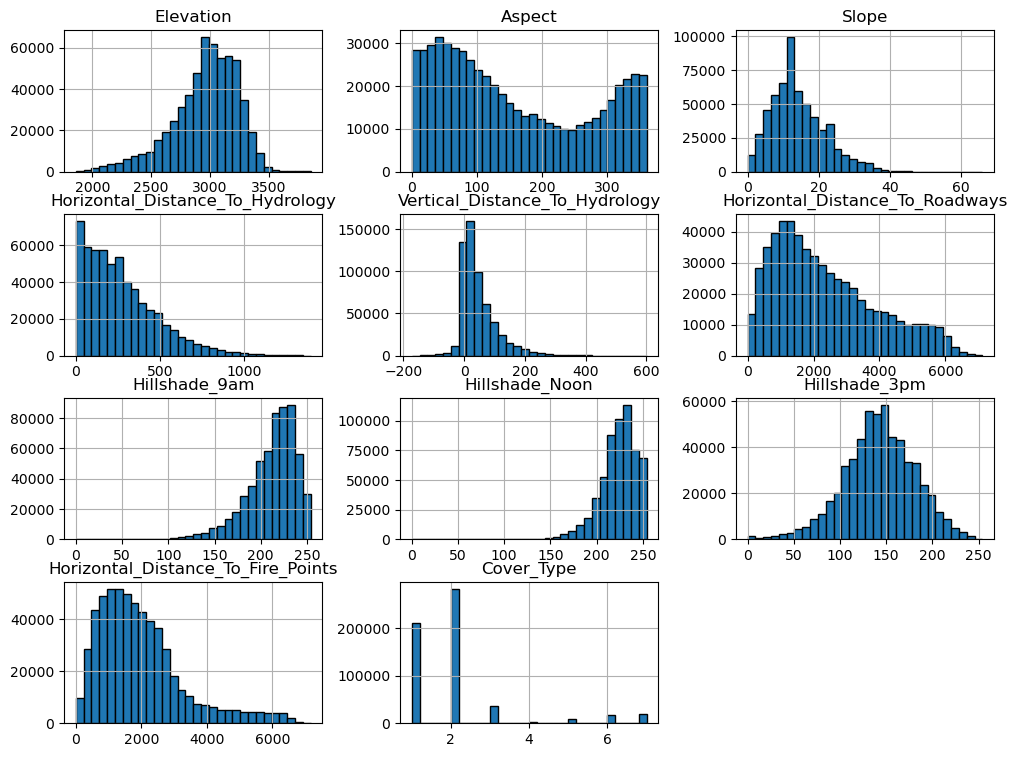

In [6]:
# Plot a histogram of the continuous variables, and the target variable
df_cont = df.drop(['Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40'], axis=1)

# Plot histogram of all continuous variable
df_cont.hist(figsize=(12, 9), bins=30, edgecolor="black")

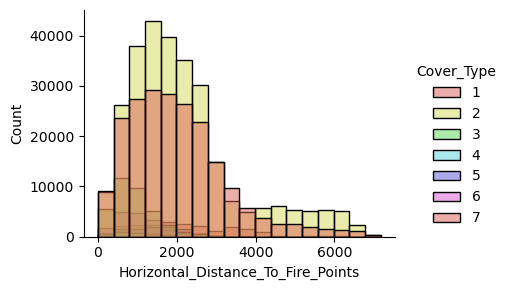

In [7]:
# Out of interest, let's plot a histogram of variables that aren't intuitive to relate to each other
sns.displot(data=df, x='Horizontal_Distance_To_Fire_Points', bins=18,
            height=3, aspect=1.4, hue='Cover_Type',
            palette='hls')

# ANN and SVM Runs

In [8]:
# From previous pipelines: activation, solver, validation fraction, learning rate, hidden layer sizes 
# these were the best parameters before I tested alpha and tolerance

#ann_pipeline = Pipeline([('ANNcls', MLPClassifier(early_stopping=True, n_iter_no_change=5, max_iter=500,
#                                                  learning_rate='adaptive', solver='sgd', validation_fraction=0.1,
#                                                 hidden_layer_sizes=(20,50,20), activation='relu'))])
            
#params = [{'ANNcls__alpha':[1, 0.1, 0.01, 0.001], 'ANNcls__tol':[0.0001, 0.001, 0.01, 0.1]}]

#gs_ann = GridSearchCV(ann_pipeline,
#                      param_grid=params,
#                      scoring='accuracy',
#                      cv=10)

#gs_ann.fit(X_tr_Norm, Y_tr)

#gs_ann.best_params_

In [9]:
#\sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, 
# class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)[source]

#svm_pipeline = Pipeline([('PCA', PCA()), ('svc', SVC(decision_function_shape = 'ovr'))])
            
#params = [{'PCA__n_components':[.7, .9, .999], 'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'svc__gamma':['scale', 'auto'], 'svc__degree':[2, 3, 4]}]

#gs_svm = GridSearchCV(svm_pipeline,
#                      param_grid=params,
#                      scoring='accuracy',
#                      cv=5)

#gs_svm.fit(X_tr_Norm, Y_tr.argmax(axis=1))

#gs_svm.best_params_

Starting iteration 1
Undersampling the data
Splitting the data
Normalizing the data
Running the optimized ANN
Running the optimized SVM
Plotting ROC Curves for Iteration 1


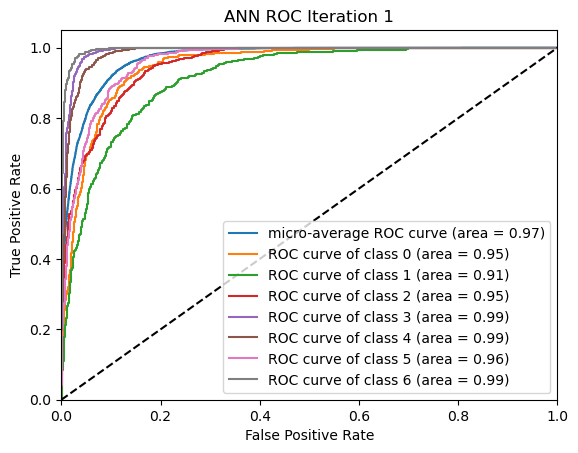

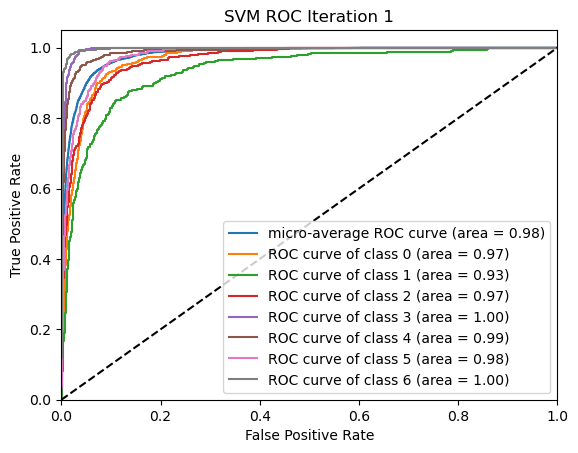

Done iteration 1, woohoo!
Starting iteration 2
Undersampling the data
Splitting the data
Normalizing the data
Running the optimized ANN
Running the optimized SVM
Plotting ROC Curves for Iteration 2


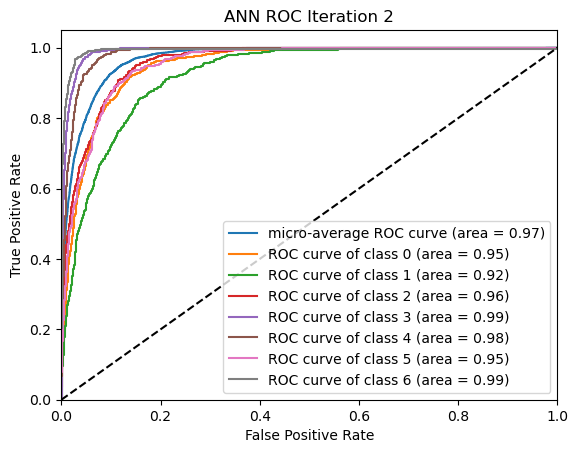

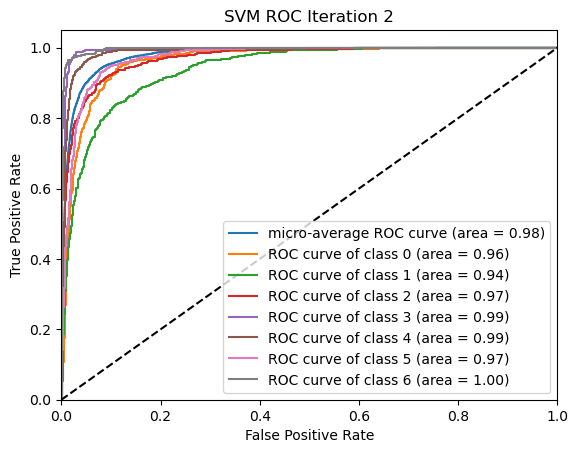

Done iteration 2, woohoo!


In [10]:
# Randomly undersample the data such that each class has the same samples as the minimum class
n_iter = 2

class_report_ann = []
cnf_matrix_ANN_tr = []
cnf_matrix_ANN_va = []

class_report_svm = []
cnf_matrix_SVM_tr = []
cnf_matrix_SVM_va = []


for ii in range(n_iter):
    
    print('Starting iteration ' + str(ii+1))
    
    print('Undersampling the data')
    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)
    #print('Resampled dataset shape %s' % Counter(y_res))

    # Practice using OneHotEncoder, although this is not necessary for this data set.
    ohe = OneHotEncoder(sparse=False)
    tar= np.reshape(y_res,(-1,1))
    tar = ohe.fit_transform(tar)
    
    print('Splitting the data')
    # Split the data into training and validation, with 20% of the data for validation. 
    #X_tr, X_va, Y_tr, Y_va = train_test_split(X_res, tar, test_size=0.20, random_state=42)
    X_tr, X_va, Y_tr, Y_va = train_test_split(X_res, tar, test_size=0.20)
    #print ('training set == ',np.shape(X_tr),np.shape(Y_tr),',, validation set == ', np.shape(X_va),np.shape(Y_va))
    
    
    print('Normalizing the data')
    # Normalize the data using the StandardScaler function, ie. center the mean of the data around 0. 
    scaler_S= StandardScaler().fit(X_tr)  # line #2
    X_tr_Norm= scaler_S.transform(X_tr) # line # 3
    X_va_Norm= scaler_S.transform(X_va)  # Line #4
    
    if n_iter == 0:
        print('Plot of Normalized vs Not Normalized Data')
        fig = plt.figure(figsize=(11, 9))
        n_col = 1
        title = 'Aspect'
        plt.subplot(2, 2, 1)
        plt.hist(X_tr[:,n_col], edgecolor='black')
        plt.title('Training set: Not Normalized')
        plt.ylabel('N')
        plt.xlabel(str(title))
        plt.subplot(2, 2, 2)
        plt.hist(X_va[:,n_col], edgecolor='black')
        plt.title('Validation set: Not Normalized')
        plt.ylabel('N')
        plt.xlabel(str(title))       
        plt.subplot(2, 2, 3)
        plt.hist(X_tr_Norm[:,n_col], edgecolor='black')
        plt.title('Training set: Normalized')
        plt.ylabel('N')
        plt.xlabel(str(title))
        plt.subplot(2, 2, 4)
        plt.hist(X_va_Norm[:,n_col], edgecolor='black')
        plt.title('Validation set: Normalized')
        plt.ylabel('N')
        plt.xlabel(str(title))  
        plt.show()
        
        # Plot a histogram of the balanced cover types 
        fig = plt.figure(figsize=(5, 3))
        plt.hist(y_res, color='orange', edgecolor='black') 
        plt.ylabel('N')
        plt.xlabel('Cover Type')
        plt.title('Balanced Cover Types')
        plt.show()

    
    # ANN: 
    print('Running the optimized ANN')
    # Create the ANN model with fine-tuned parameters 
    clf_ANN = MLPClassifier(solver='adam', activation='relu', hidden_layer_sizes=(20,50,20), 
                            max_iter=500, early_stopping=True, n_iter_no_change=5, 
                            validation_fraction=0.1, learning_rate='adaptive', random_state=42, alpha=0.1, tol=0.0001)

    ## fitting the model:
    clf_ANN.fit(X_tr_Norm, Y_tr)

    ## predict the response for tr and va sets. We can have two outputs: probability (e.g.,PY_tr_prob ) and  the winner class (e.g.,PY_tr):
    ANN_tr_prob = clf_ANN.predict_proba(X_tr_Norm)
    ANN_tr_pred = clf_ANN.predict(X_tr_Norm)

    ANN_va_prob = clf_ANN.predict_proba(X_va_Norm)
    
    # same thing as grid prediction
    ANN_va_pred = clf_ANN.predict(X_va_Norm)
    
    class_report_ann.append(classification_report(Y_va.argmax(axis=1), ANN_va_pred.argmax(axis=1), output_dict=True))
    cnf_matrix_ANN_tr.append(confusion_matrix(ANN_tr_pred.argmax(axis=1), Y_tr.argmax(axis=1)))
    cnf_matrix_ANN_va.append(confusion_matrix(ANN_va_pred.argmax(axis=1), Y_va.argmax(axis=1)))
    
    # SVM: 
    print('Running the optimized SVM')
    # Initialize the fine-tuned model
    clf_svm = SVC(decision_function_shape='ovr', kernel='rbf', gamma=0.1, C=5, tol=1, probability=True, break_ties=True)

    # Fit the model on the data 
    clf_svm.fit(X_tr_Norm, Y_tr.argmax(axis=1))
    
    # Using those parameters, determine the training and validation predictions
    SVM_tr_prob = clf_svm.predict_proba(X_tr_Norm)
    SVM_tr_pred = clf_svm.predict(X_tr_Norm)

    SVM_va_prob = clf_svm.predict_proba(X_va_Norm)
    SVM_va_pred = clf_svm.predict(X_va_Norm)
    
    class_report_svm.append(classification_report(Y_va.argmax(axis=1), SVM_va_pred, output_dict=True))
    cnf_matrix_SVM_tr.append(confusion_matrix(SVM_tr_pred, Y_tr.argmax(axis=1)))
    cnf_matrix_SVM_va.append(confusion_matrix(SVM_va_pred, Y_va.argmax(axis=1)))
    
    print('Plotting ROC Curves for Iteration ' + str(ii+1))
    plot_ROC_curve(ANN_va_prob, Y_va, title='ANN ROC Iteration ' + str(ii+1))
    plot_ROC_curve(SVM_va_prob, Y_va, title='SVM ROC Iteration ' + str(ii+1))
    
    print('Done iteration ' + str(ii+1) + ', woohoo!')

## Background Stuff

In [11]:
print(class_report_ann[0]['accuracy'])

print(class_report_ann[0])

0.734009360374415
{'0': {'precision': 0.47943722943722944, 'recall': 0.7981981981981981, 'f1-score': 0.599053414469236, 'support': 555}, '1': {'precision': 0.712166172106825, 'recall': 0.4355716878402904, 'f1-score': 0.5405405405405406, 'support': 551}, '2': {'precision': 0.8224043715846995, 'recall': 0.5336879432624113, 'f1-score': 0.6473118279569892, 'support': 564}, '3': {'precision': 0.8689075630252101, 'recall': 0.8913793103448275, 'f1-score': 0.88, 'support': 580}, '4': {'precision': 0.8243243243243243, 'recall': 0.8489065606361829, 'f1-score': 0.8364348677766894, 'support': 503}, '5': {'precision': 0.7059800664451827, 'recall': 0.7522123893805309, 'f1-score': 0.7283633247643531, 'support': 565}, '6': {'precision': 0.9325396825396826, 'recall': 0.8901515151515151, 'f1-score': 0.9108527131782945, 'support': 528}, 'accuracy': 0.734009360374415, 'macro avg': {'precision': 0.7636799156375934, 'recall': 0.7357296578305651, 'f1-score': 0.7346509555265861, 'support': 3846}, 'weighted av

In [12]:
# Calculate ANN results with error 
class0_p_ann = []
class1_p_ann = []
class2_p_ann = []
class3_p_ann = []
class4_p_ann = []
class5_p_ann = []
class6_p_ann = []

class0_r_ann = []
class1_r_ann = []
class2_r_ann = []
class3_r_ann = []
class4_r_ann = []
class5_r_ann = []
class6_r_ann = []

class0_f_ann = []
class1_f_ann = []
class2_f_ann = []
class3_f_ann = []
class4_f_ann = []
class5_f_ann = []
class6_f_ann = []

accuracy_all_ann = []

n_class = 7
for ii in range(0, n_iter):
    for ii_2 in range(0, n_class):
        if ii_2 == 0:
            class0_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class0_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class0_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 1: 
            class1_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class1_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class1_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 2: 
            class2_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class2_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class2_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 3: 
            class3_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class3_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class3_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 4: 
            class4_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class4_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class4_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 5: 
            class5_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class5_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class5_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 6: 
            class6_p_ann.append(class_report_ann[ii-1][str(ii_2)]['precision'])
            class6_r_ann.append(class_report_ann[ii-1][str(ii_2)]['recall'])
            class6_f_ann.append(class_report_ann[ii-1][str(ii_2)]['f1-score'])

    accuracy_all_ann.append(class_report_ann[ii]['accuracy'])  

print(accuracy_all_ann)

[0.734009360374415, 0.7230889235569423]


In [13]:
# Calculate svm results with error 

class0_p_svm = []
class1_p_svm = []
class2_p_svm = []
class3_p_svm = []
class4_p_svm = []
class5_p_svm = []
class6_p_svm = []

class0_r_svm = []
class1_r_svm = []
class2_r_svm = []
class3_r_svm = []
class4_r_svm = []
class5_r_svm = []
class6_r_svm = []

class0_f_svm = []
class1_f_svm = []
class2_f_svm = []
class3_f_svm = []
class4_f_svm = []
class5_f_svm = []
class6_f_svm = []

accuracy_all_svm = []

n_class = 7
for ii in range(0, n_iter):
    for ii_2 in range(0, n_class):
        if ii_2 == 0:
            class0_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class0_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class0_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 1: 
            class1_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class1_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class1_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 2: 
            class2_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class2_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class2_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 3: 
            class3_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class3_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class3_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 4: 
            class4_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class4_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class4_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 5: 
            class5_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class5_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class5_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
        if ii_2 == 6: 
            class6_p_svm.append(class_report_svm[ii-1][str(ii_2)]['precision'])
            class6_r_svm.append(class_report_svm[ii-1][str(ii_2)]['recall'])
            class6_f_svm.append(class_report_svm[ii-1][str(ii_2)]['f1-score'])
            
    accuracy_all_svm.append(class_report_svm[ii]['accuracy'])

print(accuracy_all_svm)

[0.8198127925117005, 0.8304732189287571]


## More Background Calculations
Calculating mean and standard deviation for each metric and class, for both ANN and SVM

In [14]:
class0_p_svm_avg = np.mean(class0_p_svm)
class0_p_svm_std = np.std(class0_p_svm)
class1_p_svm_avg = np.mean(class1_p_svm)
class1_p_svm_std = np.std(class1_p_svm)
class2_p_svm_avg = np.mean(class2_p_svm)
class2_p_svm_std = np.std(class2_p_svm)
class3_p_svm_avg = np.mean(class3_p_svm)
class3_p_svm_std = np.std(class3_p_svm)
class4_p_svm_avg = np.mean(class4_p_svm)
class4_p_svm_std = np.std(class4_p_svm)
class5_p_svm_avg = np.mean(class5_p_svm)
class5_p_svm_std = np.std(class5_p_svm)
class6_p_svm_avg = np.mean(class6_p_svm)
class6_p_svm_std = np.std(class6_p_svm)
class0_p_ann_avg = np.mean(class0_p_ann)
class0_p_ann_std = np.std(class0_p_ann)
class1_p_ann_avg = np.mean(class1_p_ann)
class1_p_ann_std = np.std(class1_p_ann)
class2_p_ann_avg = np.mean(class2_p_ann)
class2_p_ann_std = np.std(class2_p_ann)
class3_p_ann_avg = np.mean(class3_p_ann)
class3_p_ann_std = np.std(class3_p_ann)
class4_p_ann_avg = np.mean(class4_p_ann)
class4_p_ann_std = np.std(class4_p_ann)
class5_p_ann_avg = np.mean(class5_p_ann)
class5_p_ann_std = np.std(class5_p_ann)
class6_p_ann_avg = np.mean(class6_p_ann)
class6_p_ann_std = np.std(class6_p_ann)
class0_p_svm_avg = np.mean(class0_p_svm)
class0_p_svm_std = np.std(class0_p_svm)
class1_p_svm_avg = np.mean(class1_p_svm)
class1_p_svm_std = np.std(class1_p_svm)
class2_p_svm_avg = np.mean(class2_p_svm)
class2_p_svm_std = np.std(class2_p_svm)
class3_p_svm_avg = np.mean(class3_p_svm)
class3_p_svm_std = np.std(class3_p_svm)
class4_p_svm_avg = np.mean(class4_p_svm)
class4_p_svm_std = np.std(class4_p_svm)
class5_p_svm_avg = np.mean(class5_p_svm)
class5_p_svm_std = np.std(class5_p_svm)
class6_p_svm_avg = np.mean(class6_p_svm)
class6_p_svm_std = np.std(class6_p_svm)
class0_r_ann_avg = np.mean(class0_r_ann)
class0_r_ann_std = np.std(class0_r_ann)
class1_r_ann_avg = np.mean(class1_r_ann)
class1_r_ann_std = np.std(class1_r_ann)
class2_r_ann_avg = np.mean(class2_r_ann)
class2_r_ann_std = np.std(class2_r_ann)
class3_r_ann_avg = np.mean(class3_r_ann)
class3_r_ann_std = np.std(class3_r_ann)
class4_r_ann_avg = np.mean(class4_r_ann)
class4_r_ann_std = np.std(class4_r_ann)
class5_r_ann_avg = np.mean(class5_r_ann)
class5_r_ann_std = np.std(class5_r_ann)
class6_r_ann_avg = np.mean(class6_r_ann)
class6_r_ann_std = np.std(class6_r_ann)
class0_r_svm_avg = np.mean(class0_r_svm)
class0_r_svm_std = np.std(class0_r_svm)
class1_r_svm_avg = np.mean(class1_r_svm)
class1_r_svm_std = np.std(class1_r_svm)
class2_r_svm_avg = np.mean(class2_r_svm)
class2_r_svm_std = np.std(class2_r_svm)
class3_r_svm_avg = np.mean(class3_r_svm)
class3_r_svm_std = np.std(class3_r_svm)
class4_r_svm_avg = np.mean(class4_r_svm)
class4_r_svm_std = np.std(class4_r_svm)
class5_r_svm_avg = np.mean(class5_r_svm)
class5_r_svm_std = np.std(class5_r_svm)
class6_r_svm_avg = np.mean(class6_r_svm)
class6_r_svm_std = np.std(class6_r_svm)
class0_f_ann_avg = np.mean(class0_f_ann)
class0_f_ann_std = np.std(class0_f_ann)
class1_f_ann_avg = np.mean(class1_f_ann)
class1_f_ann_std = np.std(class1_f_ann)
class2_f_ann_avg = np.mean(class2_f_ann)
class2_f_ann_std = np.std(class2_f_ann)
class3_f_ann_avg = np.mean(class3_f_ann)
class3_f_ann_std = np.std(class3_f_ann)
class4_f_ann_avg = np.mean(class4_f_ann)
class4_f_ann_std = np.std(class4_f_ann)
class5_f_ann_avg = np.mean(class5_f_ann)
class5_f_ann_std = np.std(class5_f_ann)
class6_f_ann_avg = np.mean(class6_f_ann)
class6_f_ann_std = np.std(class6_f_ann)
class0_f_svm_avg = np.mean(class0_f_svm)
class0_f_svm_std = np.std(class0_f_svm)
class1_f_svm_avg = np.mean(class1_f_svm)
class1_f_svm_std = np.std(class1_f_svm)
class2_f_svm_avg = np.mean(class2_f_svm)
class2_f_svm_std = np.std(class2_f_svm)
class3_f_svm_avg = np.mean(class3_f_svm)
class3_f_svm_std = np.std(class3_f_svm)
class4_f_svm_avg = np.mean(class4_f_svm)
class4_f_svm_std = np.std(class4_f_svm)
class5_f_svm_avg = np.mean(class5_f_svm)
class5_f_svm_std = np.std(class5_f_svm)
class6_f_svm_avg = np.mean(class6_f_svm)
class6_f_svm_std = np.std(class6_f_svm)
accuracy_all_ann_avg = np.mean(accuracy_all_ann)
accuracy_all_ann_std = np.std(accuracy_all_ann)
accuracy_all_svm_avg = np.mean(accuracy_all_svm)
accuracy_all_svm_std = np.std(accuracy_all_svm)

In [15]:
#create data
data = [["1", class0_p_ann_avg, class0_p_ann_std, class0_r_ann_avg, class0_r_ann_std, class0_f_ann_avg, class0_f_ann_std], 
        ["2", class1_p_ann_avg, class1_p_ann_std, class1_r_ann_avg, class1_r_ann_std, class1_f_ann_avg, class1_f_ann_std],
       ["3", class2_p_ann_avg, class2_p_ann_std, class2_r_ann_avg, class2_r_ann_std, class2_f_ann_avg, class2_f_ann_std],
       ["4", class3_p_ann_avg, class3_p_ann_std, class3_r_ann_avg, class3_r_ann_std, class3_f_ann_avg, class3_f_ann_std],
       ["5", class4_p_ann_avg, class4_p_ann_std, class4_r_ann_avg, class4_r_ann_std, class4_f_ann_avg, class4_f_ann_std],
       ["6", class5_p_ann_avg, class5_p_ann_std, class5_r_ann_avg, class5_r_ann_std, class5_f_ann_avg, class1_f_ann_std],
       ["7", class6_p_ann_avg, class6_p_ann_std, class6_r_ann_avg, class6_r_ann_std, class6_f_ann_avg, class6_f_ann_std]]

#define header names
col_names = ["Class", "Precision", "Std Precision", "Recall", "Std Recall", "F1", "Std F1"]

#create data
data_svm = [["1", class0_p_svm_avg, class0_p_svm_std, class0_r_svm_avg, class0_r_svm_std, class0_f_svm_avg, class0_f_svm_std], 
        ["2", class1_p_svm_avg, class1_p_svm_std, class1_r_svm_avg, class1_r_svm_std, class1_f_svm_avg, class1_f_svm_std],
       ["3", class2_p_svm_avg, class2_p_svm_std, class2_r_svm_avg, class2_r_svm_std, class2_f_svm_avg, class2_f_svm_std],
       ["4", class3_p_svm_avg, class3_p_svm_std, class3_r_svm_avg, class3_r_svm_std, class3_f_svm_avg, class3_f_svm_std],
       ["5", class4_p_svm_avg, class4_p_svm_std, class4_r_svm_avg, class4_r_svm_std, class4_f_svm_avg, class4_f_svm_std],
       ["6", class5_p_svm_avg, class5_p_svm_std, class5_r_svm_avg, class5_r_svm_std, class5_f_svm_avg, class1_f_svm_std],
       ["7", class6_p_svm_avg, class6_p_svm_std, class6_r_svm_avg, class6_r_svm_std, class6_f_svm_avg, class6_f_svm_std]]
  
#define header names
col_names_svm = ["Class", "Precision", "Std Precision", "Recall", "Std Recall", "F1", "Std F1"]

In [16]:
all_conf_ANN_tr = cnf_matrix_ANN_tr[0]
for conf in range(1,n_iter): 
    all_conf_ANN_tr += cnf_matrix_ANN_tr[conf]

all_conf_ANN_va = cnf_matrix_ANN_va[0]
for conf in range(1,n_iter): 
    all_conf_ANN_va += cnf_matrix_ANN_va[conf]
    
all_conf_SVM_tr = cnf_matrix_SVM_tr[0]
for conf in range(1,n_iter): 
    all_conf_SVM_tr += cnf_matrix_SVM_tr[conf]

all_conf_SVM_va = cnf_matrix_SVM_va[0]
for conf in range(1,n_iter): 
    all_conf_SVM_va += cnf_matrix_SVM_va[conf]


# Results

## Confusion Matrices 

Normalized confusion matrix


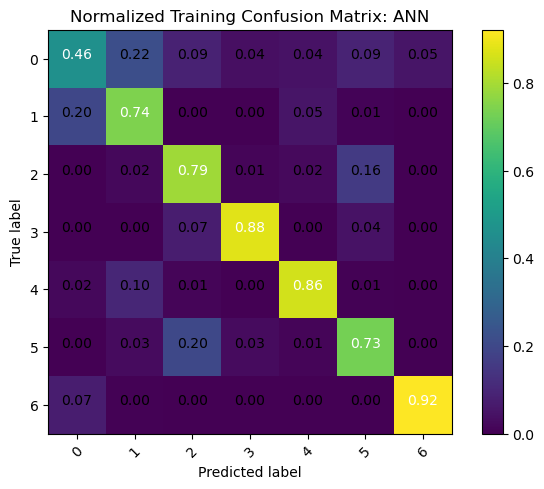

Normalized confusion matrix


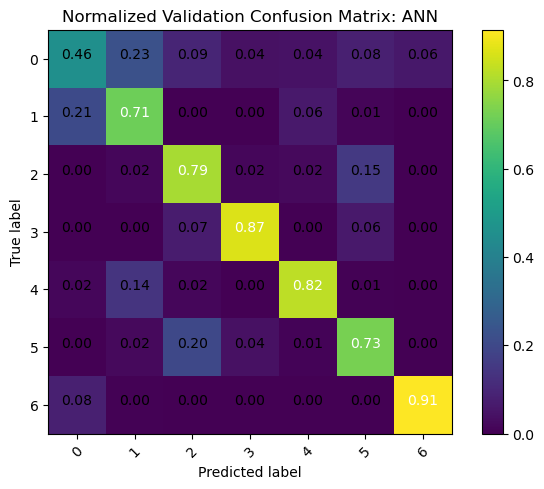

In [17]:
plot_confusion_matrix(all_conf_ANN_tr, classes=['0','1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized Training Confusion Matrix: ANN')

plot_confusion_matrix(all_conf_ANN_va, classes=['0','1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized Validation Confusion Matrix: ANN')

Normalized confusion matrix


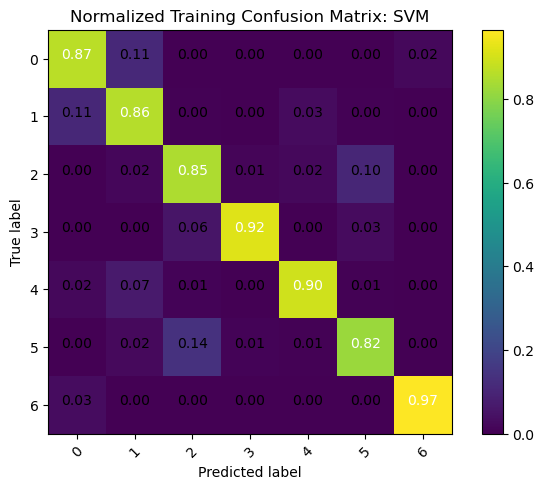

Normalized confusion matrix


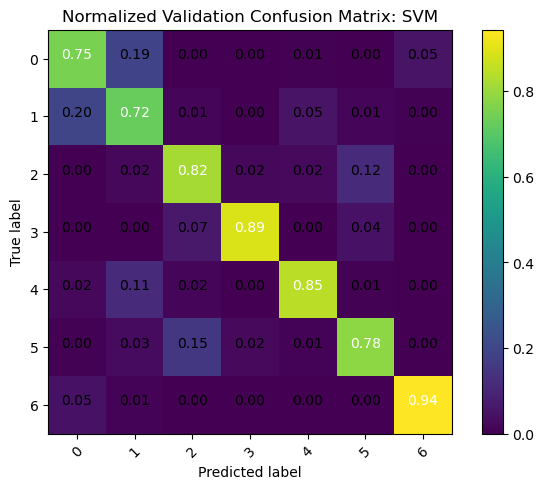

In [18]:
plot_confusion_matrix(all_conf_SVM_tr, classes=['0','1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized Training Confusion Matrix: SVM')

plot_confusion_matrix(all_conf_SVM_va, classes=['0','1', '2', '3', '4', '5', '6'], normalize=True,
                      title='Normalized Validation Confusion Matrix: SVM')

## Precision, Recall, F1, Accuracy, and Standard Deviations

In [19]:
print(str(n_iter) + ' Runs of Randomly Undersampled Shuffled Data')
print('')
#display table
print('ANN Results')
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))
print('Accuracy of ANN is ' + str(round(accuracy_all_ann_avg, 2)) + ' with standard deviation of ' + str(round(accuracy_all_ann_std,3)))
print('')
#display table
print('SVM Results')
print(tabulate(data_svm, headers=col_names_svm, tablefmt="fancy_grid"))
print('Accuracy of SVM is ' + str(round(accuracy_all_svm_avg, 2)) + ' with standard deviation of ' + str(round(accuracy_all_svm_std, 3)))

2 Runs of Randomly Undersampled Shuffled Data

ANN Results
╒═════════╤═════════════╤═════════════════╤══════════╤══════════════╤══════════╤════════════╕
│   Class │   Precision │   Std Precision │   Recall │   Std Recall │       F1 │     Std F1 │
╞═════════╪═════════════╪═════════════════╪══════════╪══════════════╪══════════╪════════════╡
│       1 │    0.45531  │     0.0241272   │ 0.77247  │   0.0257285  │ 0.572874 │ 0.0261797  │
├─────────┼─────────────┼─────────────────┼──────────┼──────────────┼──────────┼────────────┤
│       2 │    0.71444  │     0.00227385  │ 0.444083 │   0.00851111 │ 0.547683 │ 0.00714201 │
├─────────┼─────────────┼─────────────────┼──────────┼──────────────┼──────────┼────────────┤
│       3 │    0.796665 │     0.0257396   │ 0.579344 │   0.045656   │ 0.668824 │ 0.0215117  │
├─────────┼─────────────┼─────────────────┼──────────┼──────────────┼──────────┼────────────┤
│       4 │    0.867425 │     0.00148277  │ 0.884222 │   0.00715755 │ 0.875734 │ 0.00426618 │
├

# Conclusion

# References 

**Forest Cover Dataset:**
https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://stackoverflow.com/questions/53454977/use-bagging-classifier-with-a-support-vector-machine-model